## workflow to practice running OGGM - focus on glaciers of Araucania, Chile
* run: mamba activate oggm_env to get started

In [ ]:
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, global_tasks, DEFAULT_BASE_URL
# It will download a small subset of data used for testing and calibration 
# Those data are located in your home directory, in a hidden folder called .oggm
from oggm.sandbox import distribute_2d
from oggm.core import massbalance, flowline
from oggm.core.massbalance import mb_calibration_from_scalar_mb, mb_calibration_from_geodetic_mb, mb_calibration_from_wgms_mb

cfg.initialize()
# It will create a configuration file in your home folder, where you can indicate where you want to store further input data. 
# This configuration file is also located in your home directory under the name .oggm_config.

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import seaborn as sns

2025-05-13 15:56:07: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-05-13 15:56:07: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-05-13 15:56:07: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [ ]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')
# A call to cfg.initialize() will read the default parameter file (or any user-provided file) and
# make them available to all other OGGM tools via the cfg.PARAMS dictionary. 

cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']
cfg.PARAMS['border'] = 10
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
#cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-calib-mb', reset=True)

2025-05-13 14:19:40: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-05-13 14:19:40: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-05-13 14:19:40: oggm.cfg: Multiprocessing: using all available processors (N=8)
2025-05-13 14:19:40: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-05-13 14:19:40: oggm.cfg: Multiprocessing switched ON after user settings.


In the OGGM design, this working directory is meant to be persistent, at least as long as you need the data. For example, you can stop your processing workflow after any task, and restart from an existing working directory at a later stage, simply by using the same working directory.

In [3]:
# define the glaciers for the run 
# Here I use the glaciers of Araucania, Chile: Tolhuaca, Lonquimay (x2), Sierra Nevada (x3), Llaima (x2)
rgi_ids = ['RGI60-17.12848', 'RGI60-17.12821', 'RGI60-17.12823', 'RGI60-17.12780', 'RGI60-17.12781', 'RGI60-17.12795', 'RGI60-17.12714', 'RGI60-17.12721'] 


In [4]:
# Let’s use OGGM to download the glacier directories for our selected glaciers:
gdirs = workflow.init_glacier_directories(
    rgi_ids,  # which glaciers?
    prepro_base_url=DEFAULT_BASE_URL,  # where to fetch the data?
    from_prepro_level=4,  # what kind of data? (e.g. can try with 3 for mb data?)
    prepro_border=80  # how big of a map? (zoom level)
)

## add a last number (e.g. [0] or [1] to define which glacier in list of gdirs to run scenarios for)

2025-05-13 14:38:14: oggm.workflow: init_glacier_directories from prepro level 4 on 8 glaciers.
2025-05-13 14:38:14: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 8 glaciers
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% of 283.9 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% of 283.9 MiB |                      | Elapsed Time: 0:00:15 ETA:   0:18:49
  1% of 283.9 MiB |                      | Elapsed Time: 0:00:15 ETA:   0:13:23
  1% of 283.9 

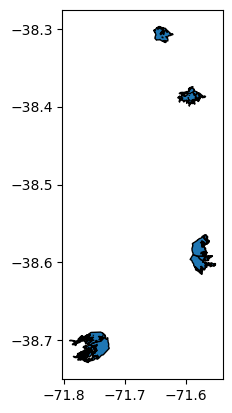

In [5]:
# if want to plot glaciers with no background map
al = utils.get_rgi_glacier_entities(rgi_ids, version='62')
al.plot(edgecolor='k');

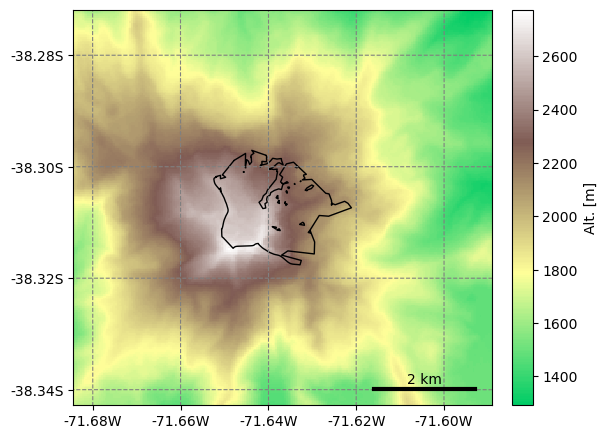

In [ ]:
#alternative map option, can't figure out how to get all in the image though
from oggm import graphics
graphics.plot_domain(gdirs, figsize=(6, 5))

In [ ]:
# mass balance estimation for each glacier! over 20 year period 
for gdir in gdirs:
    mbmod = massbalance.MonthlyTIModel(gdir)
    mean_mb = mbmod.get_specific_mb(fls=gdir.read_pickle('inversion_flowlines'),
                                               year=np.arange(2000,2020,1)).mean()
    print(gdir.rgi_id, f': average MB 2000-2020 = {mean_mb:.1f} kg m-2, ',
          f"prcp_fac: {gdir.read_json('mb_calib')['prcp_fac']:.2f}")

RGI60-17.12848 : average MB 2000-2020 = -431.8 kg m-2,  prcp_fac: 1.85
RGI60-17.12821 : average MB 2000-2020 = 32.4 kg m-2,  prcp_fac: 2.13
RGI60-17.12823 : average MB 2000-2020 = -27.8 kg m-2,  prcp_fac: 1.98
RGI60-17.12780 : average MB 2000-2020 = -212.3 kg m-2,  prcp_fac: 1.51
RGI60-17.12781 : average MB 2000-2020 = -447.6 kg m-2,  prcp_fac: 1.51
RGI60-17.12795 : average MB 2000-2020 = -416.7 kg m-2,  prcp_fac: 1.51
RGI60-17.12714 : average MB 2000-2020 = -405.9 kg m-2,  prcp_fac: 1.51
RGI60-17.12721 : average MB 2000-2020 = -278.2 kg m-2,  prcp_fac: 1.51


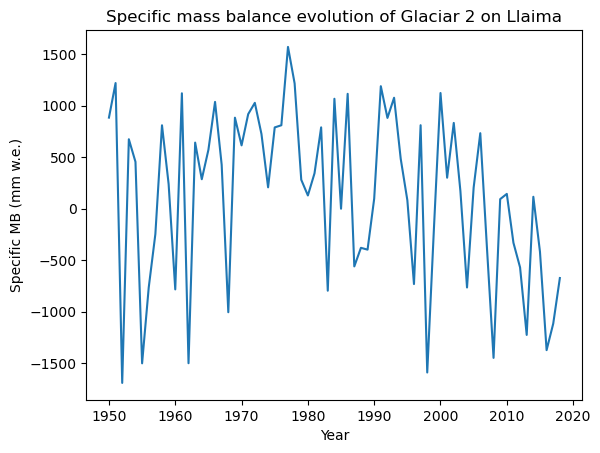

In [20]:
# computing mass balance from static directory 
# Get the calibrated mass-balance model - the default is to use OGGM's "MonthlyTIModel"
mbmod = massbalance.MultipleFlowlineMassBalance(gdir)
# just computing mass balance for one of the glaciers on Llaima

# Compute the specific MB for this glacier
fls = gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');
plt.title('Specific mass balance evolution of Glaciar 2 on Llaima');

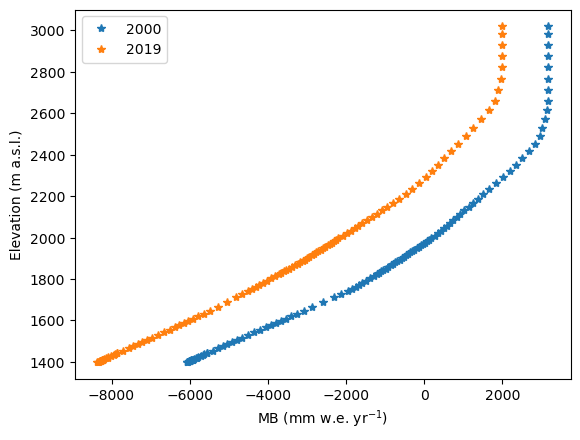

In [21]:
# Where the flowlines are:
heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2000)
# units kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 

# Plot
plt.plot(mb, heights, '*', label='2000');

# Another year: (2019 is the latest you can do i guess)
heights, widths, mb = mbmod.get_annual_mb_on_flowlines(fls, year=2019)
# units kg ice per second to mm w.e. per year:
mb = mb * cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density'] 

# Plot
plt.plot(mb, heights, '*', label='2019');
plt.ylabel('Elevation (m a.s.l.)'); plt.xlabel('MB (mm w.e. yr$^{-1}$)'); plt.legend();

In [22]:
# We want to use these flowline files for the AAR (see later)
cfg.PARAMS['store_fl_diagnostics'] = True
# Run from outline inventory year (2003 for HEF) to 2017 (end of CRU data in hydro year convention, see below)
tasks.run_from_climate_data(gdir, ye=2020);

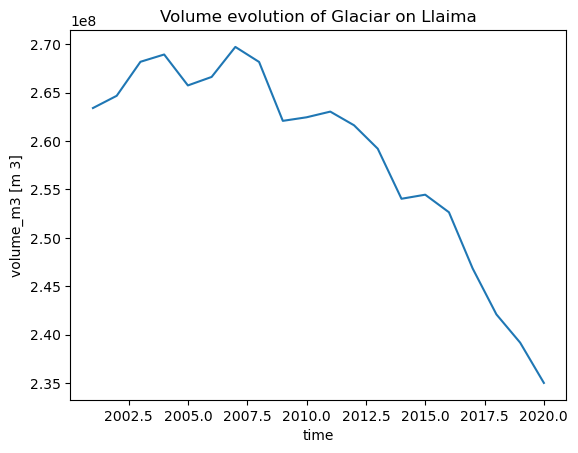

In [23]:
ds_diag = xr.open_dataset(gdir.get_filepath('model_diagnostics'))
ds_diag.volume_m3.plot(); plt.title('Volume evolution of Glaciar on Llaima');

## Warming Scenarios

In [24]:
# Do a random run with a bit of warming
tasks.run_random_climate(gdir, 
                         ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2009, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=1.5,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

In [27]:
# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

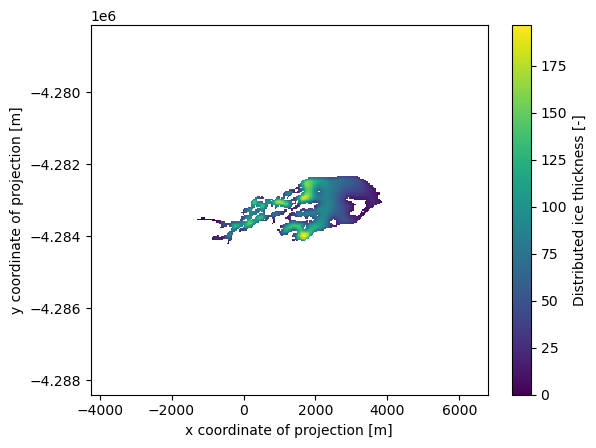

In [28]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

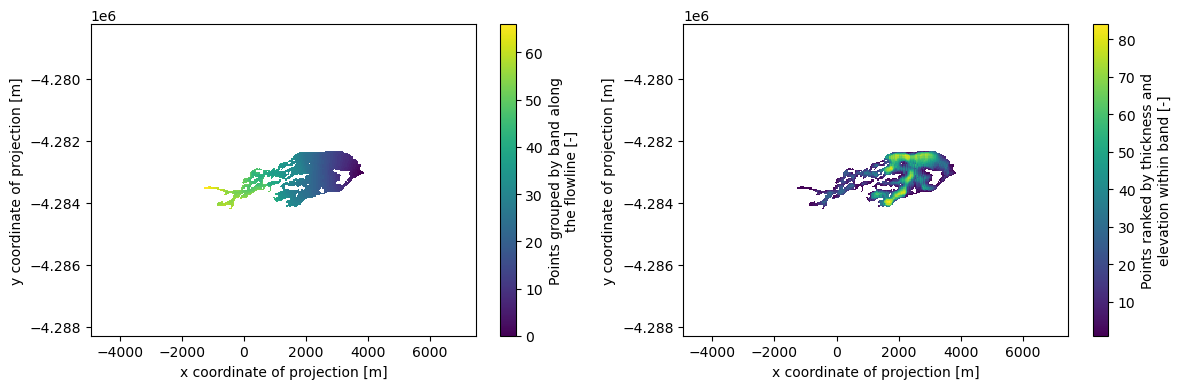

In [29]:
# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.band_index.plot(ax=ax1);
ds.rank_per_band.plot(ax=ax2);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

# Individual glacier exploration

In [ ]:
# Pick the glacier you want! Here I use Glaciar Nevado 
glaciar_sierranevada = ['RGI60-17.12780']
# one of the sierra nevada glaciers: 'RGI60-17.12780', 'RGI60-17.12781', 'RGI60-17.12795',

# Where to store the data 
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-centerlines', reset=True)

# We start from prepro level 3 with all data ready - note the url here
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/'
sierra_gdirs = workflow.init_glacier_directories(glaciar_sierranevada, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
sierra_gdir_cl = sierra_gdirs[0]
sierra_gdir_cl

2025-05-13 15:57:53: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-05-13 15:57:53: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-05-13 15:57:53: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/RGI62/b_080/L3/RGI60-17/RGI60-17.12.tar to /Users/milliespencer/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/centerlines/W5E5/RGI62/b_080/L3/RGI60-17/RGI60-17.12.tar...
  0% of 204.8 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
 40% of 204.8 MiB |########              | Elapsed Time: 0:00:15 ETA:   0:00:22
 70% of 204.8 MiB |###############       | Elapsed Time: 0:00:30 ETA:   0:00:12
 83% of 204.8 MiB |##################    | Elapsed Time: 0:00:45 ETA:   0:00:09
 95% of 204.8 MiB |##################### | Elapsed Time: 0:01:00 ETA:   0:00:02
 96% of 204.8 MiB |##################### | Elapsed Time: 0:01:

<oggm.GlacierDirectory>
  RGI id: RGI60-17.12780
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.861 km2
  Lon, Lat: (-71.5695, -38.5943)
  Grid (nx, ny): (253, 193)
  Grid (dx, dy): (23.0, -23.0)

In [34]:
# Elevation band flowline
# New working directory
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-elevbands', reset=True)

# Note the new url
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/'
sierra_gdirs = workflow.init_glacier_directories(glaciar_sierranevada, from_prepro_level=3, prepro_border=80, prepro_base_url=base_url)
sierra_gdir_eb = sierra_gdirs[0]
sierra_gdir_eb

2025-05-13 15:59:42: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2025-05-13 15:59:42: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-05-13 15:59:42: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/RGI62/b_080/L3/RGI60-17/RGI60-17.12.tar to /Users/milliespencer/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5/RGI62/b_080/L3/RGI60-17/RGI60-17.12.tar...
  0% of 195.1 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
 35% of 195.1 MiB |#######               | Elapsed Time: 0:00:15 ETA:   0:00:26
 74% of 195.1 MiB |################      | Elapsed Time: 0:00:30 ETA:   0:00:10
100% of 195.1 MiB |######################| Elapsed Time: 0:00:36 Time:  0:00:36


<oggm.GlacierDirectory>
  RGI id: RGI60-17.12780
  Region: 17: Southern Andes
  Subregion: 17-02: C Andes                         
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.861 km2
  Lon, Lat: (-71.5695, -38.5943)
  Grid (nx, ny): (253, 193)
  Grid (dx, dy): (23.0, -23.0)

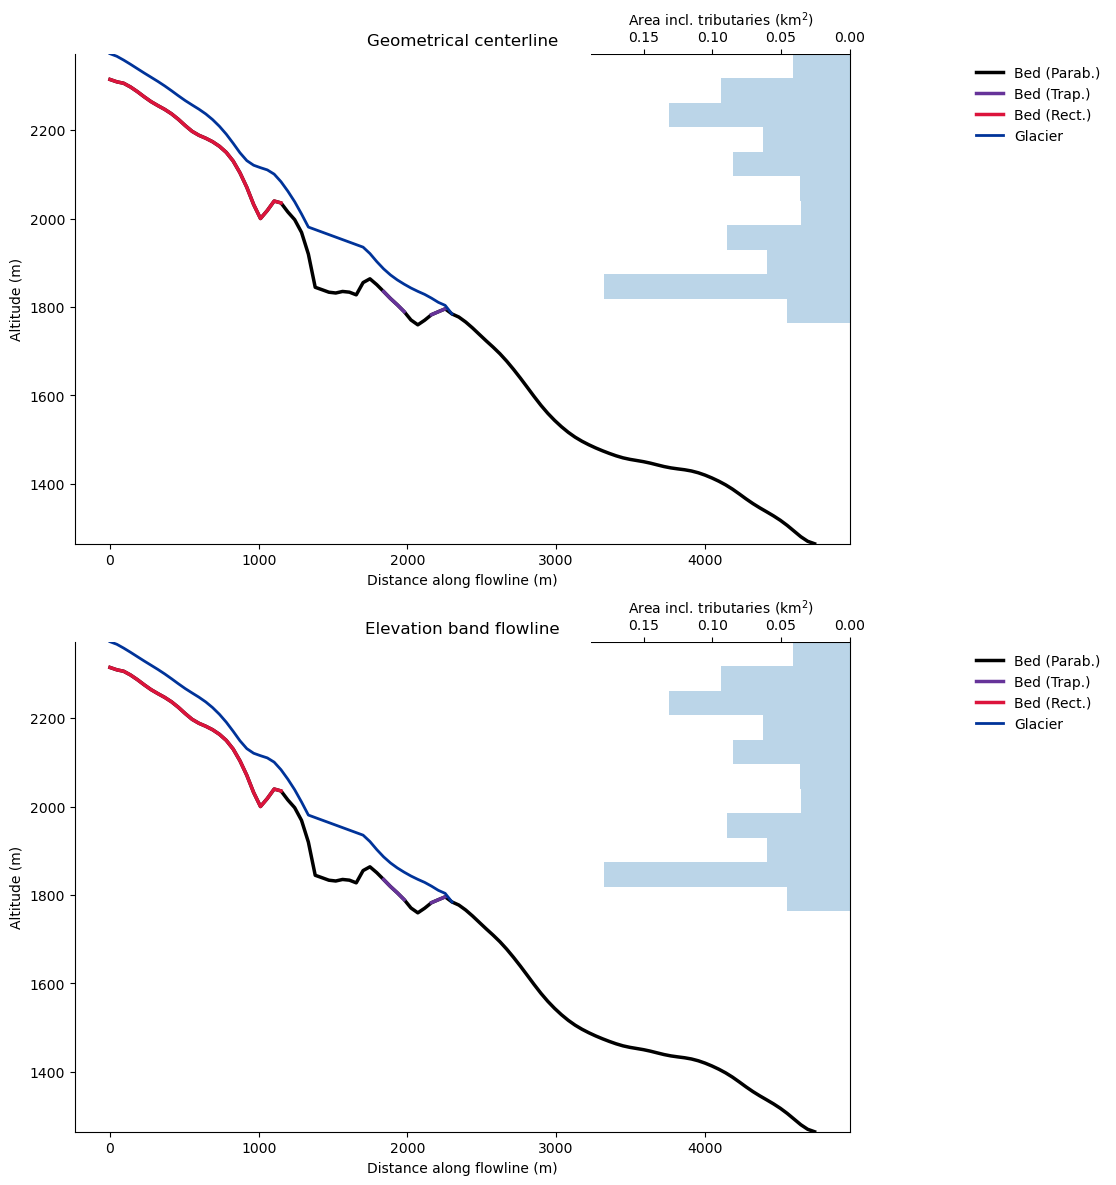

In [35]:
# glacier length and cross-section 
fls_cl = sierra_gdir_cl.read_pickle('model_flowlines')
fls_eb = sierra_gdir_cl.read_pickle('model_flowlines')

# plot 
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14), sharex=True, sharey=True)
graphics.plot_modeloutput_section(fls_cl, ax=ax1)
ax1.set_title('Geometrical centerline')
graphics.plot_modeloutput_section(fls_eb, ax=ax2)
ax2.set_title('Elevation band flowline');

In [36]:
sierra_gdirs = [sierra_gdir_cl, sierra_gdir_eb]

from oggm.shop import gcm_climate

# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, sierra_gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                 );

2025-05-13 16:01:04: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 2 glaciers
2025-05-13 16:01:04: oggm.shop.gcm_climate: (RGI60-17.12780) process_monthly_isimip_data_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126
2025-05-13 16:01:04: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~oggm//cmip6/isimip3b/flat/2023.2/monthly/mri-esm2-0_r1i1p1f1_w5e5_ssp126_tasAdjust_global_monthly_flat_glaciers.nc to /Users/milliespencer/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm//cmip6/isimip3b/flat/2023.2/monthly/mri-esm2-0_r1i1p1f1_w5e5_ssp126_tasAdjust_global_monthly_flat_glaciers.nc...
  0% of  18.6 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
100% of  18.6 MiB |######################| Elapsed Time: 0:00:04 Time:  0:00:04
2025-05-13 16:01:09: oggm.utils: Downloading https://cluster.klima.uni-bremen.de/~oggm//cmip6/isimip3b/flat/2023.2/monthly/mri-esm2-0_r1i1p1f1_w5e5_historical_tasAdjust_global_monthly_flat_glaciers.nc to /Users/milliespencer/O

In [37]:
# add additional outputs to default OGGM
cfg.PARAMS['store_model_geometry'] = True  
cfg.PARAMS['store_fl_diagnostics'] = True

for nevado_gdir in sierra_gdirs:
    if nevado_gdir is sierra_gdir_cl:
        cfg.PARAMS['evolution_model'] = 'FluxBased'
    else:
        cfg.PARAMS['evolution_model'] = 'SemiImplicit'

    workflow.execute_entity_task(tasks.run_from_climate_data, [nevado_gdir],
                                 output_filesuffix='_historical',  
                                );

    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'

        workflow.execute_entity_task(tasks.run_from_climate_data, [nevado_gdir],
                                     climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                     climate_input_filesuffix=rid,  # use the chosen scenario
                                     init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                                     output_filesuffix=rid,  # recognize the run for later
                                    );

2025-05-13 16:02:26: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2025-05-13 16:02:26: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.
2025-05-13 16:02:26: oggm.cfg: PARAMS['evolution_model'] changed from `SemiImplicit` to `FluxBased`.
2025-05-13 16:02:26: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-05-13 16:02:26: oggm.core.flowline: (RGI60-17.12780) run_from_climate_data_historical
2025-05-13 16:02:26: oggm.core.flowline: (RGI60-17.12780) flowline_model_run_historical
2025-05-13 16:02:26: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-05-13 16:02:26: oggm.core.flowline: (RGI60-17.12780) run_from_climate_data_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126
2025-05-13 16:02:26: oggm.core.flowline: (RGI60-17.12780) flowline_model_run_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126
2025-05-13 16:02:26: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2025-05-13 16:02:2

In [38]:
rid = f'_ISIMIP3b_{member}_ssp126'

In [39]:
cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

In [40]:
sierra_gdir = workflow.init_glacier_directories(glaciar_sierranevada, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]

2025-05-13 16:04:34: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2025-05-13 16:04:34: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


In [41]:
# Do a random run with a bit of warming
tasks.run_random_climate(sierra_gdir, 
                         ys=2020, ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
                         y0=2009, halfsize=10,  # Randome climate of 1999-2019
                         seed=1,  # Random number generator seed 
                         temperature_bias=1.5,  # additional warming - change for other scenarios
                         store_fl_diagnostics=True,  # important! This will be needed for the redistribution
                         init_model_filesuffix='_spinup_historical',  # start from the spinup run
                         output_filesuffix='_random_s1',  # optional - here I just want to make things explicit as to which run we are using afterwards
                        );

2025-05-13 16:04:55: oggm.core.flowline: (RGI60-17.12780) run_random_climate_random_s1
2025-05-13 16:04:55: oggm.core.flowline: (RGI60-17.12780) flowline_model_run_random_s1


In [43]:
from oggm.sandbox import distribute_2d

# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(sierra_gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(sierra_gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(sierra_gdir)

with xr.open_dataset(sierra_gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

2025-05-13 16:05:32: oggm.sandbox.distribute_2d: (RGI60-17.12780) add_smoothed_glacier_topo
2025-05-13 16:05:32: oggm.core.inversion: (RGI60-17.12780) distribute_thickness_per_altitude
2025-05-13 16:05:32: oggm.core.gis: (RGI60-17.12780) gridded_attributes
2025-05-13 16:05:32: oggm.sandbox.distribute_2d: (RGI60-17.12780) assign_points_to_band


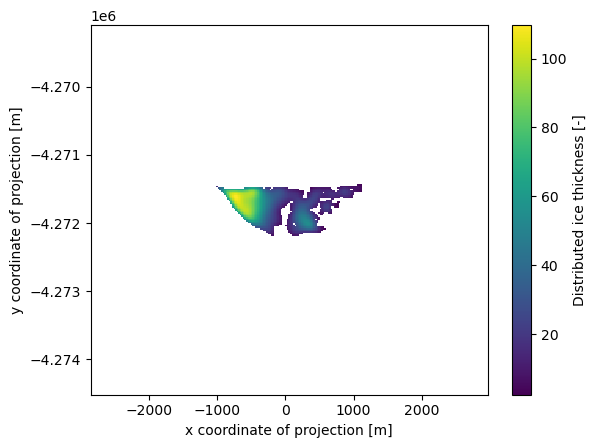

In [44]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax);
ax.axis('equal');

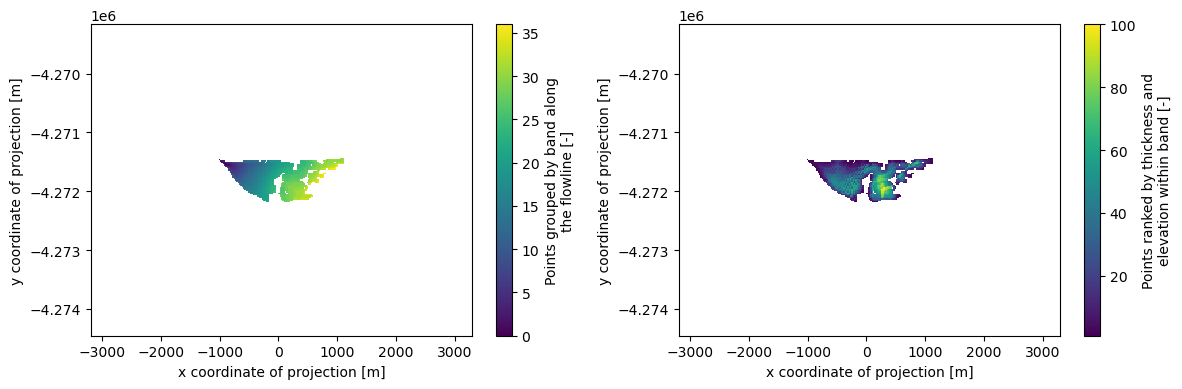

In [45]:
# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.band_index.plot(ax=ax1);
ds.rank_per_band.plot(ax=ax2);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

In [46]:
ds = distribute_2d.distribute_thickness_from_simulation(sierra_gdir, 
                                                        input_filesuffix='_random_s1',  # Use the simulation we just did
                                                        concat_input_filesuffix='_spinup_historical',  # Concatenate with the historical spinup
                                                        )

2025-05-13 16:06:15: oggm.sandbox.distribute_2d: (RGI60-17.12780) distribute_thickness_from_simulation


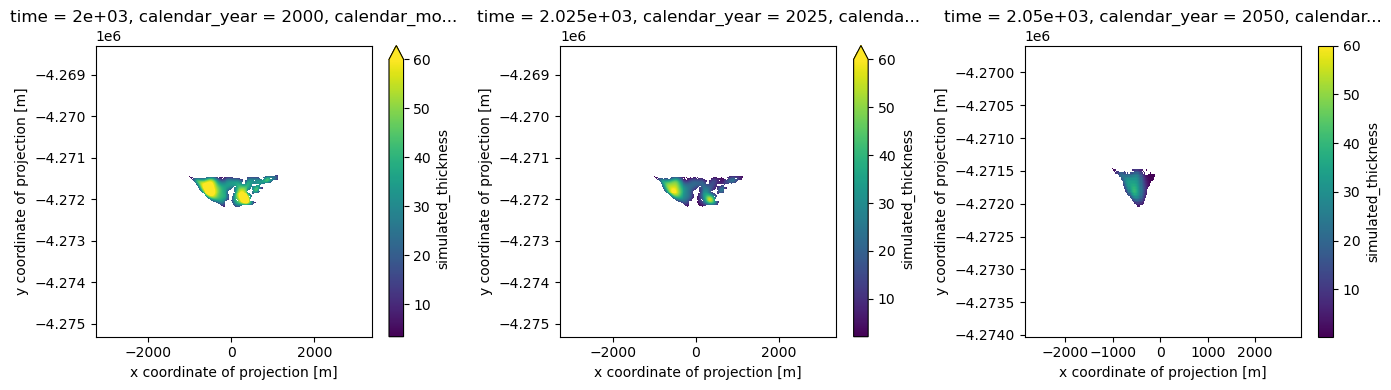

In [47]:
# # Plot
# f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
# ds.distributed_thickness.sel(time=2000).plot(ax=ax1, vmax=400);
# ds.distributed_thickness.sel(time=2050).plot(ax=ax2, vmax=400);
# ds.distributed_thickness.sel(time=2100).plot(ax=ax3, vmax=400);
# ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();
# was getting an error that distributed thickness wasnt an attribute in the dataset, so trying simulated thickness instead: 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
ds.simulated_thickness.sel(time=2000).plot(ax=ax1, vmax=60);
ds.simulated_thickness.sel(time=2025).plot(ax=ax2, vmax=60);
ds.simulated_thickness.sel(time=2050).plot(ax=ax3, vmax=60);
ax1.axis('equal'); ax2.axis('equal'); plt.tight_layout();

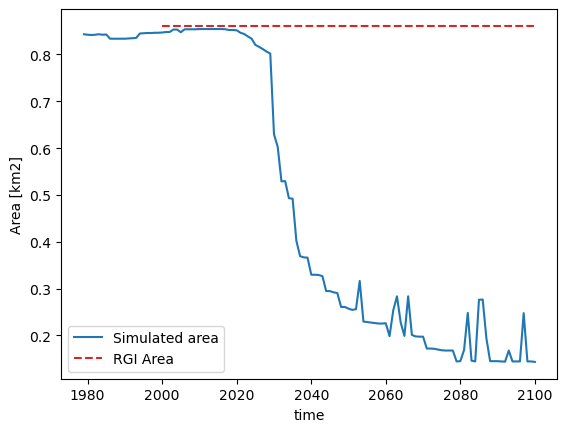

In [48]:
area = (ds.simulated_thickness > 0).sum(dim=['x', 'y']) * sierra_gdir.grid.dx**2 * 1e-6
area.plot(label='Simulated area');
plt.hlines(sierra_gdir.rgi_area_km2, sierra_gdir.rgi_date, 2100, color='C3', linestyles='--', label='RGI Area');
plt.legend(loc='lower left'); plt.ylabel('Area [km2]');

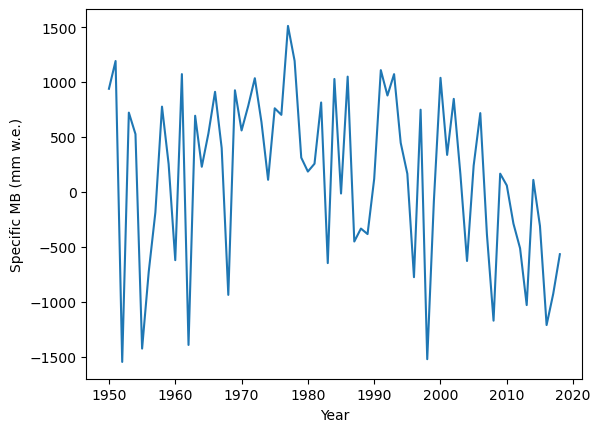

In [49]:
# computing mass balance from static directory 
# Get the calibrated mass-balance model - the default is to use OGGM's "MonthlyTIModel"
mbmod = massbalance.MultipleFlowlineMassBalance(sierra_gdir)
# i think this is just computing mass balance for glaciar nevado (# 16) 

# Compute the specific MB for this glacier
fls = sierra_gdir.read_pickle('model_flowlines')
years = np.arange(1950, 2019)
mb_ts = mbmod.get_specific_mb(fls=fls, year=years)

plt.plot(years, mb_ts);
plt.ylabel('Specific MB (mm w.e.)');
plt.xlabel('Year');